The data is related with direct marketing campaigns of a Portuguese banking institution.

Objective:
The classification goal is to predict if the client will subscribe(yes/no) to a term deposit (variable y).

Attribute Information:
1. age (numeric)
2. job : type of job (categorical:'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical:'divorced','married','single','unknown'; note: 'divorced'means divorced or widowed)
4. education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default : has credit in default? (categorical:'no','yes','unknown')
6. balance : average yearly balance, in euros (numeric)
7. housing : has housing loan? (categorical:'no','yes','unknown')
8. loan : has personal loan? (categorical: 'no','yes','unknown')
9. contact : contact communication type (categorical:'cellular','telephone')
10. day : last contact day of the month (numeric 1 -31)
11. month : last contact month of year (categorical: 'jan', 'feb','mar', ..., 'nov', 'dec')
12. duration : last contact duration, in seconds (numeric).
Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is
not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should
only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive
model.
13. campaign : number of contacts performed during this campaign and for this client (numeric, includes last
contact)
14. pdays : number of days that passed by after the client was last contacted from a previous campaign (numeric;
999 means client was not previously contacted)
15. previous : number of contacts performed before this campaign and for this client (numeric)
16. poutcome : outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
17. target : has the client subscribed a term deposit? (binary:"yes","no")

# Import all necessary modules and load the data

In [224]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....

In [159]:
bank_df = pd.read_csv('bank-full.csv')

# Print 10 samples from the dataset

In [27]:
bank_df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [85]:
# Print the datatypes of each column and the shape of the dataset
bank_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
Target       object
dtype: object

In [131]:
bank_df.shape#Its clear that majority are categorical columns and there some inconsistnet data values as well

(45211, 16)

In [166]:
#converting Target and other 'yes/no' to int values of 1,0 so as to see numerical correlations better
new_bank_df = bank_df.replace(('yes', 'no'), (1, 0))

In [127]:
#Visually we could see that 'pdays' has -ve values which are not consistent with the kind of values it represents.
#Need to test other numerical columns for -ve values
numerical_col_names = ['age','day','duration','campaign','previous']#cols which need to be tested for -ve values
numerical_cols_with_neg = []
for col_name in numerical_col_names:
    if bank_df[col_name].min()<0 :
        numerical_cols_with_neg.append(col_name)
numerical_cols_with_neg

[]

In [118]:
#From the above empty array we could conclude none of the cols in 'numerical_col_names' need to be analyzed further for -ve values

In [119]:
bank_df.pdays.value_counts()

-1      36954
 182      167
 92       147
 183      126
 91       126
 181      117
 370       99
 184       85
 364       77
 95        74
 350       73
 94        72
 175       71
 185       68
 93        65
 343       65
 188       64
 189       60
 186       60
 174       57
 96        57
 349       57
 363       55
 97        54
 90        54
 196       51
 365       51
 368       49
 342       49
 98        49
        ...  
 774        1
 550        1
 396        1
 492        1
 466        1
 45         1
 434        1
 18         1
 529        1
 465        1
 401        1
 784        1
 656        1
 592        1
 528        1
 464        1
 432        1
 655        1
 495        1
 543        1
 47         1
 782        1
 686        1
 558        1
 526        1
 749        1
 717        1
 589        1
 493        1
 32         1
Name: pdays, Length: 559, dtype: int64

In [152]:
#new_bank_df.drop(['pdays'], axis=1, inplace=True)#dropping pdays column

In [153]:
#Column 'pdays' has more than 80% -ve values as well as its significance doesnt seem too much and so we get rid of it (column no.13).
#bank_df.drop(['pdays'], axis=1, inplace=True)#dropping pdays column

In [154]:
bank_df.isnull().sum()#checking for null values

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
previous     0
poutcome     0
Target       0
dtype: int64

In [155]:
bank_df.shape#No. of cols would have decreased to 16

(45211, 16)

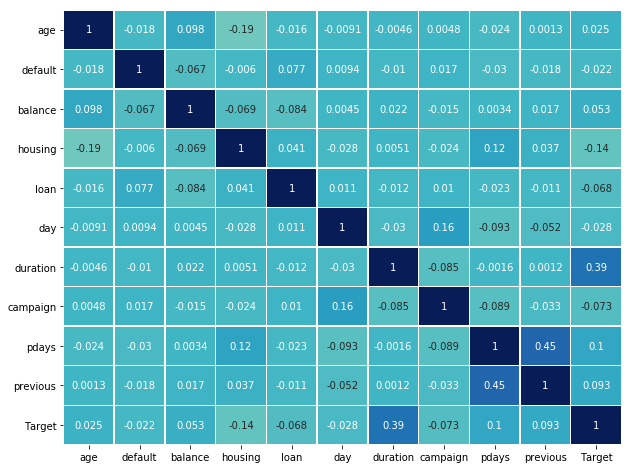

In [167]:
plt.figure(figsize=(10,8))
sns.heatmap(new_bank_df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

In [ ]:
#From the above graph we could see that there is a good correlation between 'Target' and 'duration' columns.

In [63]:
#There are no null values in any columns
#Splitting the dataset into training features and target of training and test values

In [168]:
msk = np.random.rand(len(bank_df)) < .8
features = [0,1,3,4,5,6,7,8,9,10,11,12,13,14]
X_train = bank_df[msk].iloc[:,features]
X_test = bank_df[~msk].iloc[:,features]
y_train = bank_df[msk].iloc[:,15]
y_test = bank_df[~msk].iloc[:,15]
X_train_ordinal = X_train.values
X_test_ordinal = X_test.values

In [169]:
#Using OneHotEncoder for category values and turn it into a binary vector
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_ordinal)
X_train_one_hot = enc.transform(X_train_ordinal)
X_test_one_hot = enc.transform(X_test_ordinal)

In [180]:
rfcl = RandomForestClassifier(n_estimators = 25)#since the data is of limited size we use only 25 estimators
rfcl.fit(X_train_one_hot,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [181]:
pred_RF = rfcl.predict(X_test_one_hot)
acc_RF = accuracy_score(y_test, pred_RF)
acc_RF

0.928634264350121

In [182]:
rfcl = RandomForestClassifier(n_estimators = 10)
rfcl.fit(X_train_one_hot,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [183]:
pred_RF = rfcl.predict(X_test_one_hot)
acc_RF = accuracy_score(y_test, pred_RF)
acc_RF

0.9274246756102925

In [ ]:
#From the above simple tuning of the hyper-parameter 'n_estimators' from 25 to 10 we see only a minor improvement in the score

In [184]:
rfcl = RandomForestClassifier(n_estimators = 10, criterion='entropy')
rfcl.fit(X_train_one_hot,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [185]:
pred_RF = rfcl.predict(X_test_one_hot)
acc_RF = accuracy_score(y_test, pred_RF)
acc_RF

0.9247855729052122

In [203]:
#Again after tuning for the hyper-parameter 'criterion' from 25 to 10 we see only a minor improvement in the score

## Create the decision tree model using “entropy” method of finding the split columns and fit it to training data.

In [193]:
# invoking the decision tree classifier function. Using 'entropy' method of finding the split columns.
model_entropy=DecisionTreeClassifier(criterion='entropy')

In [195]:
model_entropy.fit(X_train_one_hot,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [199]:
pred = model_entropy.predict(X_test_one_hot)
accuracy = accuracy_score(y_test, pred)
accuracy

0.9187376292060699

#### Compared to the decision tree, we can see that the accuracy is better for the Random forest model

## Apply Adaboost Ensemble Algorithm for the same data and print the accuracy.

In [197]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier( n_estimators= 100, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train_one_hot,y_train)

In [200]:
pred = abcl.predict(X_test_one_hot)
accuracy = accuracy_score(y_test, pred)
accuracy

0.9242357598416538

In [207]:
abcl = AdaBoostClassifier( n_estimators= 25, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train_one_hot,y_train)

In [208]:
pred = abcl.predict(X_test_one_hot)
accuracy = accuracy_score(y_test, pred)
accuracy

0.9242357598416538

#### Adaboost classifier performs better than Decision tree but not as good as Random forest

### Apply Bagging Classifier Algorithm and print the accuracy.

In [205]:
bgcl = BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train_one_hot,y_train)

In [206]:
pred = bgcl.predict(X_test_one_hot)
accuracy = accuracy_score(y_test, pred)
accuracy

0.9283043765119859

In [209]:
bgcl = BaggingClassifier(n_estimators=25, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train_one_hot,y_train)

In [210]:
pred = bgcl.predict(X_test_one_hot)
accuracy = accuracy_score(y_test, pred)
accuracy

0.929294040026391

#### Bagging classifier performs better than Random forest as well with same number of estimators

### Apply GradientBoost Classifier Algorithm for the same data and print the accuracy

In [220]:
gbcl = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.7, random_state=22)
gbcl = gbcl.fit(X_train_one_hot,y_train)

In [221]:
pred = gbcl.predict(X_test_one_hot)
accuracy = accuracy_score(y_test, pred)
accuracy

0.928964152188256

In [222]:
gbcl = GradientBoostingClassifier(n_estimators = 25, learning_rate = 0.7, random_state=22)
gbcl = gbcl.fit(X_train_one_hot,y_train)

In [223]:
pred = gbcl.predict(X_test_one_hot)
accuracy = accuracy_score(y_test, pred)
accuracy

0.9300637783153728

#### Gradient boost classifier performs better than Random forest as well as Bagging classifier with same number of estimators

#### For this dataset, Random forest and bagging models give the best results on test predictions